In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools, os, torch

from sim import Scheduler, Random, Leitner
from data_process import process_original, reduce_df, eval_thresh, reduce_lexemes
from get_trajectory import get_traj

%load_ext autoreload
%autoreload 2

## Load data (clean if necesarry)

In [3]:
if not os.path.exists("data/cleaned.csv"):
    process_original()
    

df = pd.read_csv("data/cleaned.csv")

## Data Exploration

In [4]:
lang_map = {'de' : 0, 'en': 1, 'es': 2, 'fr': 3, 'it': 4, 'pt': 5}
l_map = pd.read_csv("data/lexeme_map.csv")

df.groupby('learning_language').count().loc[:, 'user_id']

learning_language
0    1452597
1    5014791
2    3407689
3    1873734
4     793935
5     311480
Name: user_id, dtype: int64

We have about 5 million english items, 3 million Spanish 1.9 million French and 1.4 million German. Italian and Portugese each have hundreds of thousands. It would be useful to restrict out studies to just the English users so we reduce the dimensionality of our action and state spaces.

There are 43.8 thousand learners (trajectories) we have to provide our RL agents.



In [5]:
df = df.loc[df['learning_language'] == 1].copy()
df = df.drop(['learning_language'], axis=1)
reduce_df(df)
df.loc[:, 'difficulty'] = df.loc[:, 'difficulty'].astype(np.float32)

In [6]:
english_counts = df.groupby('lexeme_id').count().loc[:, 'timestamp']
n_lex = len(english_counts)
print(f"There are {n_lex} lexemes")

There are 2983 lexemes


In [7]:
n_items = int(500)

eval_thresh(df, english_counts, n_items)

For threshold 500 there are 24.81% lexemes above and 75.19% below

There would be 94.46% of data included and 5.54% of data excluded


In [8]:
idx_to_lex , lex_to_idx = {}, {}
df, included = reduce_lexemes(df, n_items)

states, actions, i_t_l, l_t_i = get_traj(df, included)

## Run behavioral cloning

In [49]:
import torch.nn as nn
import torch
import random
import cs285.infrastructure.pytorch_util as ptu

In [50]:
traj_idxs = list(states.keys())
def sample_traj(states, actions, batch_size):
    idxs = random.choices(traj_idxs, k=batch_size)
    first_idx = idxs.pop()
    states_cat = states[first_idx]
    actions_cat = actions[first_idx]
    while states_cat.shape[0] < batch_size:
        new_idx = idxs.pop()
        states_cat = np.concatenate((states_cat, states[new_idx]))
        actions_cat = np.concatenate((actions_cat, actions[new_idx]))
    return states_cat, actions_cat

In [60]:
state1, act1 = sample_traj(states, actions, 1)
input_size = state1.shape[1]
output_size = act1.shape[1]
hidden_size = 128
hidden_num = 2
activation = nn.Sigmoid
bc_loss = nn.MSELoss()
layers = [nn.Linear(input_size, hidden_size), activation()]
for i in range(hidden_num):
    layers.append(nn.Linear(hidden_size, hidden_size))
    layers.append(activation())
layers.append(nn.Linear(hidden_size, output_size))
bc_nn = nn.Sequential(*layers)
optimizer = torch.optim.Adam(bc_nn.parameters(), lr=.00005)

In [61]:
train_iters = 1000
losses = []
batch_size = 100

for i in range(train_iters):
    optimizer.zero_grad()
    s, a = sample_traj(states, actions, batch_size)
    result = bc_nn(ptu.from_numpy(s))
    loss = bc_loss(result, ptu.from_numpy(a))
    loss.backward()
    optimizer.step()
    losses.append(loss)

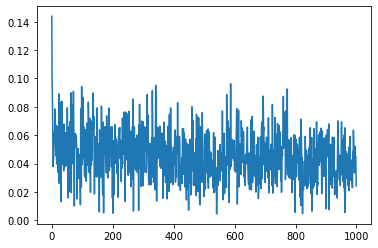

In [59]:
plt.plot(losses)